In [2]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
c=299792458.

In [3]:
fList=n.arange(50,210,10)

In [4]:
#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    


class Beam:
    def __init__(self,dirName,fList,nside,pols=['XX','YY'],rotateY=False,invert=False):
        self.nf=len(fList)
        self.fAxis=n.zeros(self.nf)
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.pixArea=hp.nside2pixarea(self.nSide)
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data=n.zeros((self.npols,self.nf,self.nPix))
        if(rotateY):
            pols.append('YY')
        self.pols=pols
        for m in range(self.nf):
            print m
            tempf=fList[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            if(len(tempf)>1):
                self.fAxis[m]+=float(tempf[1])/10.**(len(tempf[1]))*1e6
            for np in range(self.npolsOriginal):
                data=n.loadtxt('../data/beams/%s/%s_%s_%s.txt'%(dirName,dirName,fList[m],self.pols[np]),skiprows=2);
                self.data[np,m,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
                if(invert):
                    self.data[np,m,:]=rotateBeam(self.data[np,m,:].flatten(),rot=[0,180,0])
                self.data[np,m,:]/=self.data[np,m,:].flatten().max(); 
                self.data[np,m,theta>90.]=0.
                self.solidAngles[np,m]=self.pixArea*n.sum(self.data[np,m,:])
                self.effArea[np,m]=(c/(self.fAxis[m]))**2./self.solidAngles[np,m]
            if(self.npolsOriginal==1):
                self.data[1,m,:]=rotateBeam(self.data[0,m,:].flatten())
                self.solidAngles[1,m]=self.pixArea*n.sum(self.data[1,m,:])
                self.effArea[1,m]=(c/(self.fAxis[m]))**2./self.solidAngles[1,m]
            if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
                self.ellipticity[m]=n.sum((self.data[0,m]-self.data[1,m])**2.)/n.sum((self.data[0,m]+self.data[1,m])**2.)
                


In [13]:
#beamCylinder=Beam('beamCylinder',['100'],64)
#fstrList=['050','060','070','080','090','100','110','120','130','140','150']
fstrListHigh=['100','110','120','130','140','150','160','170','180','190','200']


#beamCylinder=Beam('beamCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True,invert=True)
#beamBareDipole=Beam('beamBareDipoleFeedOnly_v2',fstrList,64,['XX'],rotateY=True,invert=True)
#beamPickets=Beam('beamPicketCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True,invert=True)
beamHighFreq=Beam('beamHighBandFeedOnly',fstrListHigh,64,['XX'],rotateY=True,invert=False)







0
1
2
3
4
5
6
7
8
9
10


In [14]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=data[hp.ang2pix(nSide,thetaVals,phiVals)]
    return output
    #take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=hp.get_interp_val(data,thetaVals,phiVals)
    return output

/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


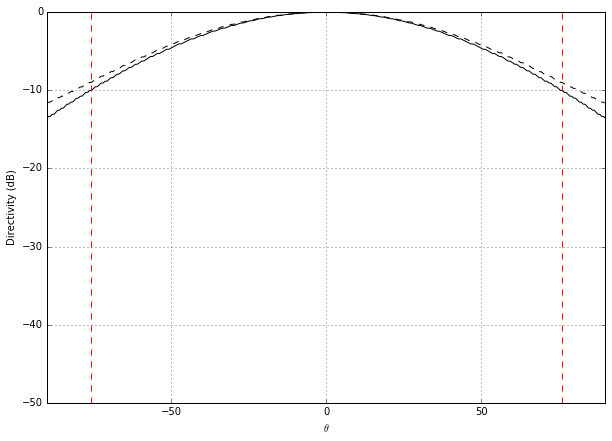

In [15]:
nth=800
tha=n.degrees(n.arange(-nth/2,nth/2)*pi/nth)
#p.plot(tha,hpCut(0,nth,10*n.log10(beamCylinder.data[0,3,:])),color='k',ls='--')
#l1=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamCylinder.data[0,3,:])),color='k')[0]

p.plot(tha,hpCut(0,nth,10*n.log10(beamHighFreq.data[0,0,:])),color='k',ls='--')
l1=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamHighFreq.data[0,0,:])),color='k')[0]



#p.plot(tha,hpCut(0,nth,10*n.log10(beamNoCylinder.data[0,5,:])),color='r',ls='--')
#l2=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamNoCylinder.data[0,5,:])),color='r')[0]

#p.plot(tha,hpCut(0,nth,10*n.log10(beamNoBackPlane.dataXX[5,:])),color='b',ls='--')
#l3=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamNoBackPlane.dataXX[5,:])),color='b')[0]


#p.plot(tha,hpCut(0,nth,10*n.log10(beamPickets.data[0,3,:])),color='red',ls='--')
#l3=p.plot(tha,hpCut(pi/2.,nth,10*n.log10(beamPickets.data[0,3,:])),color='red')[0]

#p.gcf().legend((l1),('Cylinder and Backplane'),loc='upper center')#,ncol=3)
p.axvline(76,color='r',ls='--')
p.axvline(-76,color='r',ls='--')
p.grid()
p.xlabel('$\\theta$')
p.xlim(-90,90)
p.ylim(-50,0)
p.ylabel('Directivity (dB)')
p.gcf().set_size_inches([10,7])

/home/aaronew/default/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/aaronew/default/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


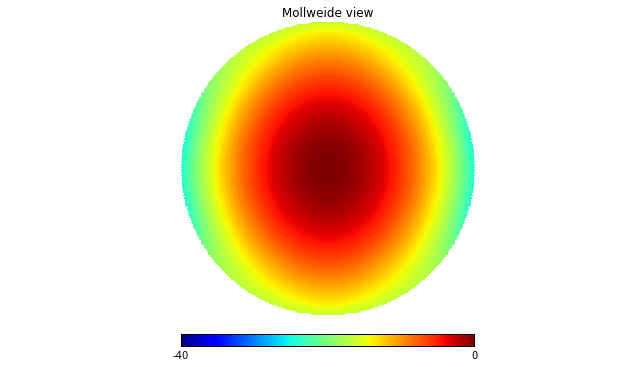

In [11]:
for m in range(5,6):
    hp.mollview(10*n.log10(beamPickets.data[0,5,:]),rot=(0,90,0),min=-40,max=0)

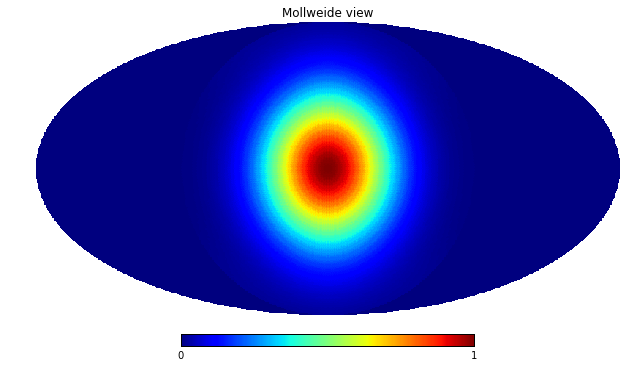

In [14]:
for m in range(5,6):
    hp.mollview((beamPickets.data[0,5,:]),rot=(0,90,0))

/home/aaronew/default/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


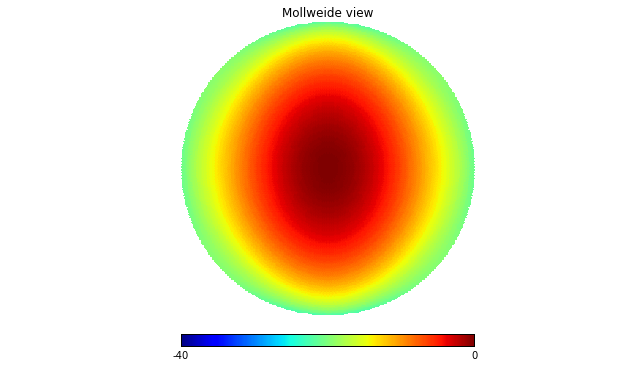

In [12]:
for m in range(5,6):
    hp.mollview(10*n.log10(beamCylinder.data[0,5,:]),rot=(0,90,0),min=-40,max=0)